### Assign sources to one of five specified task-classes, using bootstrap shuffle
### for determining significance of assignment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler
# %pdb

import os
from IPython.core.debugger import set_trace

from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
import time
import scipy.stats
import pickle

import h5py
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import consensus_score
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import KMeans

import cosmos.traces.trace_analysis_utils as utils
from cosmos.behavior.bpod_dataset import BpodDataset
import cosmos.imaging.atlas_registration as reg
from cosmos.traces.cell_plotter import CellPlotter
from cosmos.traces.cosmos_traces import CosmosTraces
import cosmos.traces.clustering_utils as cu
import cosmos.traces.task_class_utils as tcu

import cosmos.params.trace_analyze_params as params ### All variables here should be capitalized.

from scipy.stats import zscore

import matplotlib
matplotlib.rcParams.update({'xtick.major.pad': '2'})
matplotlib.rcParams.update({'ytick.major.pad': '2'})
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams['pdf.fonttype'] = 42 # truetype
matplotlib.rcParams['ps.fonttype'] = 42

/home/user/anaconda3/envs/cosmostools3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Select dataset.
workstation='cosmosdata'

if workstation == 'analysis2':
    base_dir = '/home/izkula/Dropbox/'
    # base_path = '/home/izkula/Data/processedData/'
elif workstation == 'cosmosdata':
    base_dir = '/home/user/Dropbox'


data_dir = base_dir + '/cosmos_data/'
fig_save_dir = base_dir + '/cosmos/trace_analysis/'
bpod_dir = base_dir + '/cosmos_data/behavior/'
task_classes_dir = base_dir + '/cosmos_data/task_classes/'
task_classes_figs_dir = base_dir + '/cosmos/fig_plots/fig7/'
clustering_dir = base_dir + '/cosmos_data/clustering_results/'
cluster_figs_dir = base_dir + '/cosmos/fig_plots/fig7/'

if not os.path.isdir(task_classes_dir):
    os.makedirs(task_classes_dir)

dataset_id = 7 #22 #16 #27 #35 #19 #18 #7 #11 #12 # TO TRY: 22, 23, 24, 25
dataset = params.DATASETS[dataset_id]
print(dataset)
dataset['data_root'] = data_dir
dataset['fig_save_dir'] = fig_save_dir
dataset['behavior_dir'] = bpod_dir

{'date': '20180401', 'name': 'cux2ai148m72_COSMOSTrainMultiBlockGNG_1', 'bpod_file': 'cux2m72/COSMOSTrainMultiBlockGNG/Session Data/cux2m72_COSMOSTrainMultiBlockGNG_20180401_134852.mat', 'regressors_name': 'cux2m72-20180401-134904', 'info': '***Imported this 4/2/18. Very good behavior. 1240 sources.'}


(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:211
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/polar_pre-reward.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/polar_post-reward.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/licks.pdf
Saving to:  /home/user/Dropbox/cosmos/trace_analysis/20180401/cux2ai148m72_COSMOSTrainMultiBlockGNG_1/success_rate.pdf
LED trials: 212
Processing traces.
[-34.99899927 423.99899927]
[297.73913811 301.26086189]
Elapsed time: 17.46667218208313


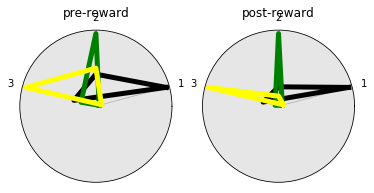

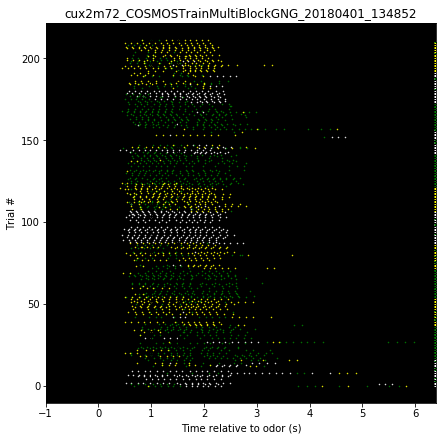

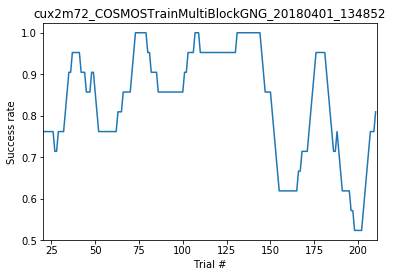

In [3]:
# Load data.
startt = time.time()

# CT = CosmosTraces(dataset, nt_per_trial=5.5)
CT = CosmosTraces(dataset) ### THIS IS THE DEFAULT, USE THIS FOR ALL BUT DATASET 38
BD = CT.bd

print('Elapsed time: '+str(time.time() - startt))

In [4]:
# Setup some analysis specific variables.
smooth_spikes = gaussian_filter1d(CT.St, 1.5, axis=1, mode='constant')

# Define trial sets.
use_all_trials = True

if use_all_trials:
    clean_trials = np.ones(BD.success.shape)
    min_block_trial = 0
    success = np.ones(BD.success.shape)
else:
    clean_trials = np.zeros(BD.success.shape)
    clean_trials[BD.get_clean_trials(min_selectivity=0.95)] = 1
    min_block_trial = 7
    success = BD.success


lick_spout1 = np.logical_and.reduce((BD.go_trials.astype('bool'), 
                                     success, 
                                     BD.spout_positions==1,
                                     BD.ind_within_block>=min_block_trial,
                                     clean_trials))
lick_spout3 = np.logical_and.reduce((BD.go_trials.astype('bool'), 
                                     success, 
                                     BD.spout_positions==3,
                                     BD.ind_within_block>=min_block_trial, 
                                     clean_trials))
lick_spout4 = np.logical_and.reduce((BD.go_trials.astype('bool'), 
                                     success, 
                                     BD.spout_positions==4,
                                     BD.ind_within_block>=min_block_trial, 
                                     clean_trials))
nolick = np.logical_and.reduce((~BD.go_trials.astype('bool'), 
                                success))

trial_sets = (lick_spout1, lick_spout3, lick_spout4, nolick)
trial_names = ('go1', 'go2', 'go3', 'ng')
type_inds = np.arange(len(trial_names))*CT.Ct.shape[1]

### You can transform the centroids and just save those out. 
centroid_atlas_coords = utils.transform_centroids_to_atlas(CT.centroids, CT.atlas_tform)


## Make a trial averaged representation for plotting the data. 
data = cu.concatenate_trial_type_avgs(trial_sets, smooth_spikes, 
                                      do_plot=False)
data = scipy.stats.zscore(data,axis=1)


### Get half datasets for cross-validated plotting of ordered traces
data_front = cu.concatenate_trial_type_avgs(trial_sets, smooth_spikes, 
                                            do_plot=False, get_first_half=True)
data_front = scipy.stats.zscore(data_front,axis=1)

data_back = cu.concatenate_trial_type_avgs(trial_sets, smooth_spikes, 
                                           do_plot=False, get_second_half=True)
data_back = scipy.stats.zscore(data_back,axis=1)



In [5]:
np.max(CT.St)

246.76677965393574

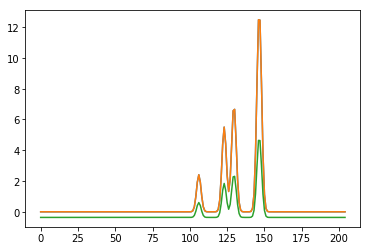

In [6]:
### Set rates here (i.e. could use fluorescence or spikes)

rates = smooth_spikes
rates_flat = np.reshape(rates, (rates.shape[0], rates.shape[1]*rates.shape[2]), order='F')
z_rates_flat = scipy.stats.zscore(rates_flat, axis=1)
z_rates = np.reshape(z_rates_flat, (rates.shape[0], rates.shape[1], rates.shape[2]), order='F')

# Double check that the reshaping is correct
plt.plot(rates_flat[1,205:410])
plt.plot(rates[1,:,1])
plt.plot(z_rates[1,:,1])

In [7]:
### Compute the mean trace from a set of training traces. 
### Compute the explained variance for each trial of the mean trace on the corresponding test traces. 
### Use n-fold cross validation. 

do_recompute_explained_variance = False
if do_recompute_explained_variance:
    t0 = time.time()

    ev_folds = dict()
    rsquared_folds = dict()
    for i in range(len(trial_sets)):
    # for i in range(1):
        trial_set = trial_sets[i]
        trial_name = trial_names[i]
        which_frames = np.arange(65, 200) # Only include odor period

        traces = rates[:, which_frames, :][:, :, trial_set]
        ev_folds[trial_name], rsquared_folds[trial_name] = tcu.cross_val_mean_ev(traces, nfolds=5)


    print(time.time() - t0)

In [8]:
### Save out test results. 
save_dir = os.path.join(task_classes_dir, str(dataset_id))
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'ev_r2.pkl')
if do_recompute_explained_variance:
    with open(save_path, 'wb') as f:
        pickle.dump({'ev_boot':ev_folds, 'rsquared_boot':rsquared_folds}, f)
else:
    with open(save_path, 'rb') as f:
        mr2 = pickle.load(f)
        rsquared_folds = mr2['rsquared_boot']
        ev_folds = mr2['ev_boot']

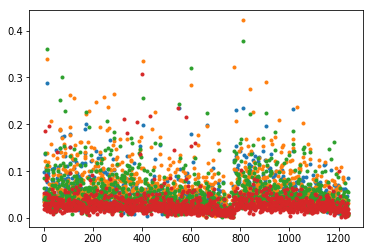

In [9]:
### Plot the results. 
plt.plot(np.mean(rsquared_folds['go1'], axis=1), '.')
plt.plot(np.mean(rsquared_folds['go2'], axis=1), '.')
plt.plot(np.mean(rsquared_folds['go3'], axis=1), '.')
plt.plot(np.mean(rsquared_folds['ng'], axis=1), '.')


In [10]:
do_run_a_single_shuffle = False

if do_run_a_single_shuffle:
    ntrials_per_shuffle = int(np.mean([np.sum(trial_sets[i]) for i in range(len(trial_sets))]))
    print(ntrials_per_shuffle)

    [ev_boot_shuff, rsquared_boot_shuff] = tcu.get_shuffle(rates, rseed=1)

In [11]:
### Parallel processing of bootstrap shuffles.

nshuff = 100
do_recompute_shuffles = False
if do_recompute_shuffles:
    import multiprocessing as mp
    t0 = time.time()
    pool = mp.Pool(15)
    results = pool.map(tcu.get_shuffle_for_parallel, list(zip([rates]*nshuff, list(np.arange(nshuff)))))
    pool.close()
    pool.join()
    print(time.time() - t0)

In [12]:
### Organize bootstrap results. 
if do_recompute_shuffles:
    ev_boot = np.zeros((len(results), results[1][0].shape[0], results[1][0].shape[1])) # Each entry is the ev_fold for a bootstrap shuffle
    rsquared_boot = np.zeros((len(results), results[0][0].shape[0], results[0][0].shape[1])) # Each entry is the ev_fold for a bootstrap shuffle
    for ind in range(len(results)):
        ev_boot[ind, :, :] = results[ind][0]
        rsquared_boot[ind, :, :] = results[ind][1]

In [13]:
## Save out (or load) results!!

save_dir = os.path.join(task_classes_dir, str(dataset_id))
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, 'boot_shuff_{}.pkl'.format(nshuff))
if do_recompute_shuffles:
    with open(save_path, 'wb') as f:
        pickle.dump({'ev_boot':ev_boot, 'rsquared_boot':rsquared_boot}, f)
else:
    with open(save_path, 'rb') as f:
        mr2 = pickle.load(f)
        rsquared_boot = mr2['rsquared_boot']
        ev_boot = mr2['ev_boot']

In [14]:
# Print the max across all shuffles (this is the significance cutoff)

rsquared_thresh = np.max(np.mean(rsquared_boot, axis=2), axis=0) # For each source, the bootstrap threshold. 
ev_thresh = np.max(np.mean(ev_boot, axis=2), axis=0) # For each source, the ev threshold. 

print('Max r^2: {}'.format(np.max(rsquared_thresh)))
print('Max ev: {}'.format(np.max(ev_thresh)))


# print('Max r^2: {}'.format(np.max(np.mean(rsquared_boot, axis=2))))
# print('Max ev: {}'.format(np.max(np.mean(ev_boot, axis=2))))

Max r^2: 0.10399949705427083
Max ev: 0.03088436672592122


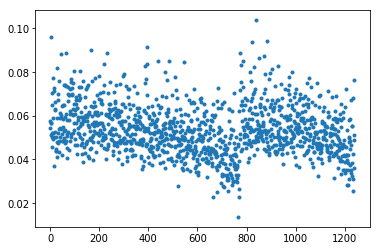

In [15]:
plt.plot(rsquared_thresh, '.')

Text(0.5,1,'Thresholded R^2')

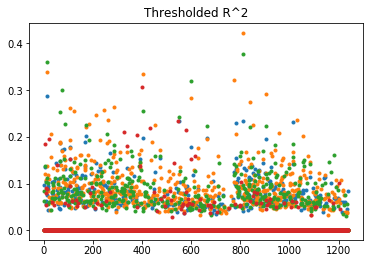

In [16]:
### Now threshold such that only significant correlations are included. 
### Threshold is per-source.
nsources = rsquared_thresh.shape[0]
threshed_rsquared = np.zeros((nsources, len(rsquared_folds.keys())))
threshed_ev = np.zeros((nsources, len(ev_folds.keys())))

for ind, key in enumerate(trial_names):
    rsquared = np.mean(rsquared_folds[key], axis=1)
    rsquared[np.where(rsquared < rsquared_thresh)[0]] = 0
    ev = np.mean(ev_folds[key], axis=1)
    ev[np.where(ev < ev_thresh)[0]] = 0
    
    threshed_rsquared[:, ind] = rsquared
    threshed_ev[:, ind] = ev
    
plt.plot(threshed_rsquared, '.')
plt.title('Thresholded R^2')

In [17]:
# normed_rsquared = np.sum(threshed_rsquared, axis=1)

/home/user/anaconda3/envs/cosmostools3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5,1,'Non-nan R^2')

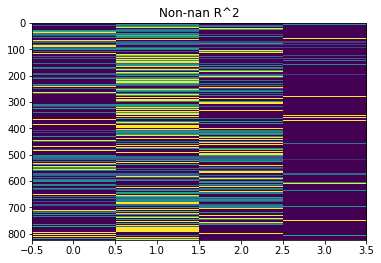

In [18]:
### Now normalize R^2 across trial types

normed_rsquared = threshed_rsquared/np.sum(threshed_rsquared, axis=1)[:, np.newaxis]
to_keep = ~np.isnan(np.sum(normed_rsquared, axis=1))
plt.imshow(normed_rsquared[to_keep,:], aspect='auto')
plt.title('Non-nan R^2')

### Define task-classes. 

In [19]:
### Initialize variable to hold the assignment of sources to each classification.
classes = dict() ### Contains lists of indices of sources in each task-related-class

In [20]:
def get_var_index(predictor, varnames):
    """Get index into ed_vars corresponding the named predictor."""
    return [i for i in range(len(varnames)) if predictor == varnames[i]][0]

def get_other_inds(predictor, varnames):
    """Get a list of all other indices except for the one corresponding to the named predictor."""
    ind = get_var_index(predictor, varnames)
    other_inds = list(np.arange(len(varnames)))
    other_inds.remove(ind)
    return other_inds

/home/user/anaconda3/envs/cosmostools3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
/home/user/anaconda3/envs/cosmostools3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/home/user/anaconda3/envs/cosmostools3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less
/home/user/anaconda3/envs/cosmostools3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less
/home/user/anaconda3/envs/cosmostools3/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in greater


Text(0.5,1,'Mixed')

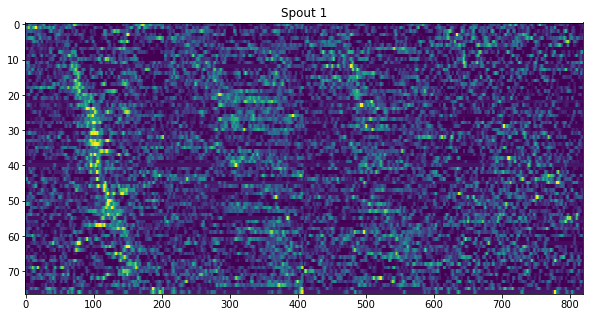

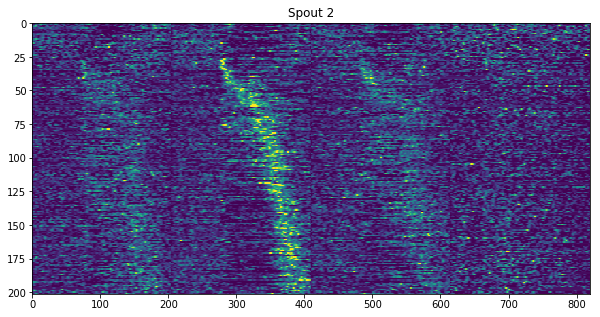

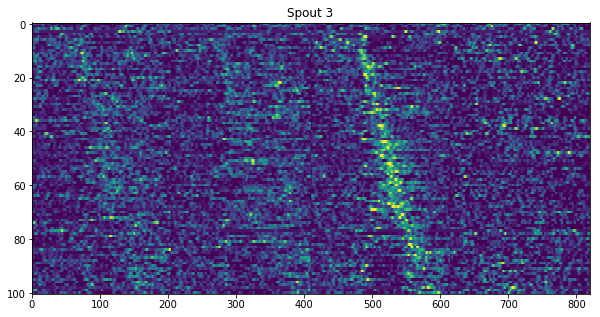

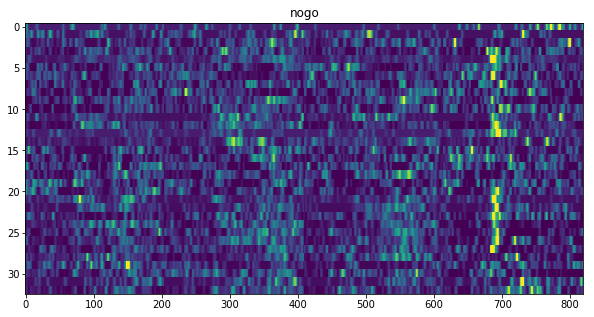

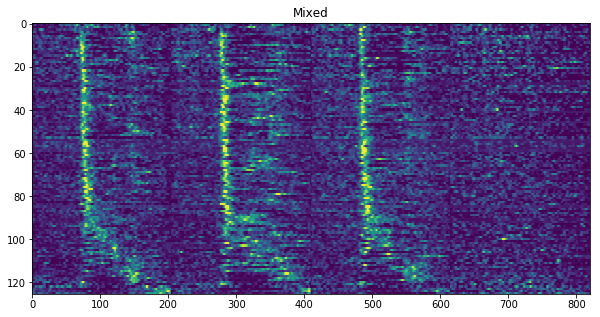

In [21]:
## Define the classes. 

class_names = ['insig', 'go1', 'go2', 'go3', 'ng', 'mixed']
trial_types = trial_names

### No significant R^2
classes[0] = np.where(~to_keep)[0]

### Spout 1
ind = get_var_index('go1', trial_types)
other_inds = get_other_inds('go1', trial_types)
classes[1] = np.where(np.logical_and(normed_rsquared[:, ind] > 0.6,
                                 np.max(normed_rsquared[:,other_inds], axis=1) < 0.3)
                                )[0]
cu.order_clusters(data_front[classes[1], :], trange=np.arange(0, 200), 
                  clust_means_to_plot=data_back[classes[1], :])
plt.title('Spout 1')

### Spout 2
ind = get_var_index('go2', trial_types)
other_inds = get_other_inds('go2', trial_types)
classes[2] = np.where(np.logical_and(normed_rsquared[:, ind] > 0.6,
                                 np.max(normed_rsquared[:,other_inds], axis=1) < 0.3)
                                )[0]
cu.order_clusters(data_front[classes[2], :], trange=np.arange(200, 400),
                  clust_means_to_plot=data_back[classes[2], :])
plt.title('Spout 2')


### Spout 3
ind = get_var_index('go3', trial_types)
other_inds = get_other_inds('go3', trial_types)
classes[3] = np.where(np.logical_and(normed_rsquared[:, ind] > 0.6,
                                 np.max(normed_rsquared[:,other_inds], axis=1) < 0.3)
                                )[0]
cu.order_clusters(data_front[classes[3], :], trange=np.arange(400, 600),
                  clust_means_to_plot=data_back[classes[3], :])
plt.title('Spout 3')

### Spout 4
ind = get_var_index('ng', trial_types)
other_inds = get_other_inds('ng', trial_types)
classes[4] = np.where(np.logical_and(normed_rsquared[:, ind] > 0.6,
                                 np.max(normed_rsquared[:,other_inds], axis=1) < 0.3)
                                )[0]
cu.order_clusters(data_front[classes[4], :], trange=np.arange(400, 600),
                  clust_means_to_plot=data_back[classes[4], :])
plt.title('nogo')

### Mixed sources
inds = [get_var_index('go1', trial_types), 
        get_var_index('go2', trial_types), 
        get_var_index('go3', trial_types)]
# classes[5] = np.where(np.logical_or(
#                         np.sum(normed_rsquared[:, inds] > 0.33, axis=1)>1,
#                         np.sum(normed_rsquared[:, inds] > 0.2, axis=1)>2)
#                       )[0]
classes[5] = np.where(np.sum(normed_rsquared[:, inds] > 0.2, axis=1)>2)[0]
cu.order_clusters(data_front[classes[5], :], trange=np.arange(0, 200),
                  clust_means_to_plot=data_back[classes[5], :])
plt.title('Mixed')

In [22]:
### Check that the classes don't overlap (they should not overlap)
overlap = False
keys = list(classes.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        intersection = [value for value in classes[keys[i]] if value in classes[keys[j]]]
        if intersection:
            print(i, j, intersection)
            overlap = True
print('Any overlap? {}'.format(overlap))

Any overlap? False


## Now, put classes in a format for fig_cluster_summary_with_glm.ipynb

In [23]:
### Assign sources to a task-related class
classification = np.zeros(CT.Ct.shape[0], dtype=int)
for c in classes.keys():
    classification[classes[c]] = int(c)

In [24]:
%pdb

Automatic pdb calling has been turned ON


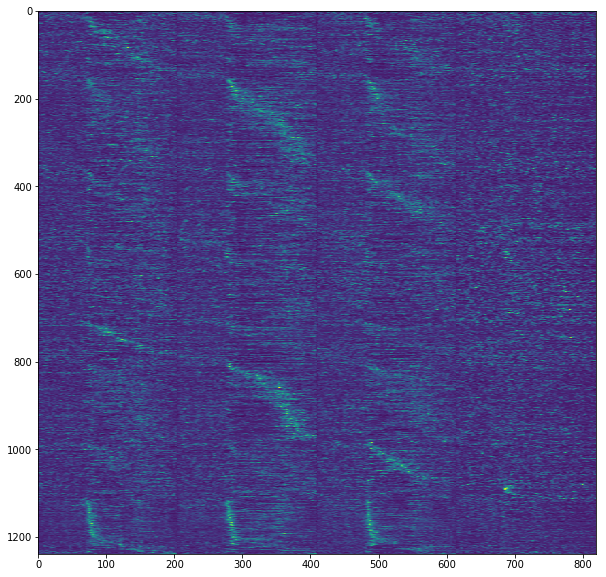

In [25]:
### Order the sources within each cluster, by peak time (this is the format fig_cluster_summary.ipynb needs.)
### What this does is: ordered_clustering is [ncells], where each entry is the argsort of that source.
### and ordered_super_clustering[i] is the task-related-class of source i.

tranges = {0: np.arange(0, 800), 1:np.arange(0, 200), 2:np.arange(200, 400), 
           3:np.arange(400, 600), 4: np.arange(600, 800), 5: np.arange(0, 200)}

# clust_ord = cu.order_super_clusters(classification, data, tranges=tranges)
clust_ord = cu.order_super_clusters(classification, data_front, tranges=tranges) ### Use one half of the traces
                                                                                 ### for ordering, so that
                                                                                 ### can then plot the other half
                                                                                 ### as a form of cross validation.


(ordered_clustering, 
 ordered_super_clustering) = cu.order_sources_by_clust(np.arange(len(classification)),
                                                       classification,
                                                       clust_ord)

#### THIS IS WHAT YOU NEED TO UPDATE WITH CROSS VALIDATED ORDERING!  TODO TODO TODO TODO


# plt.imshow(data[np.argsort(ordered_clustering), :], aspect='auto')
plt.imshow(data_back[np.argsort(ordered_clustering), :], aspect='auto')

In [26]:
r2_classes = dict()
r2_classes['class_names'] = class_names #### Need to reorder this based on ordered_super_clustering....
r2_classes['ordered_clustering'] = ordered_clustering
r2_classes['ordered_super_clustering'] = ordered_super_clustering
r2_classes['trial_sets'] = trial_sets
r2_classes['trial_names'] = trial_names
r2_classes['trial_set_inds'] = type_inds
r2_classes['centroid_atlas_coords'] = centroid_atlas_coords

filename = os.path.join(clustering_dir, 
                         '{}_{}_expt{}_r{}_n{}_l{}.pkl'.format('classify', 'mr2', 
                                                               dataset_id, 
                                                               '',
                                                               '', 
                                                               ''))
print(filename)
with open(filename, 'wb') as f:
    pickle.dump(r2_classes, f)

/home/user/Dropbox/cosmos_data/clustering_results/classify_mr2_expt7_r_n_l.pkl


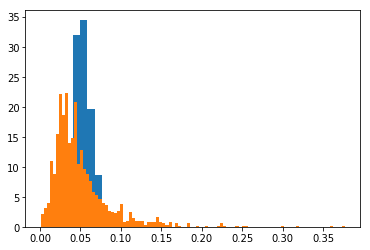

In [28]:
do_analyze_across_mice = True

if do_analyze_across_mice:
    task_classes_load_dir = base_dir + '/cosmos_data/task_classes/'

    all_mr2 = {}
    all_mr2_shuff = {}
    for d_id in [7, 11, 18, 19]:
        save_dir = os.path.join(task_classes_load_dir, str(d_id))
        save_path = os.path.join(save_dir, 'ev_r2.pkl')
        with open(save_path, 'rb') as f:
            mr2 = pickle.load(f)
        r2 = mr2['rsquared_boot']
        for key in r2.keys():
            r2[key] = np.mean(r2[key], axis=1)
        all_mr2[d_id] = r2
            
        save_dir = os.path.join(task_classes_load_dir, str(d_id))
        save_path = os.path.join(save_dir, 'boot_shuff_{}.pkl'.format(nshuff))
        with open(save_path, 'rb') as f:
            mr2_shuff = pickle.load(f)
        r2_shuff = mr2_shuff['rsquared_boot']
        all_mr2_shuff[d_id] = np.max(np.mean(r2_shuff, axis=2), axis=0)
            
    plt.hist(all_mr2_shuff[7], density=True)
    plt.hist(all_mr2[7]['go3'], bins=100, density=True)
